In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
cityname = 'Copenhagen, Denmark'

In [3]:
# Grid of 400x400m hexagons (created in QGIS)
grid = gpd.read_file(r'./data/grid_3035_COP.gpkg')
grid = grid[['id', 'geometry']]
grid.columns = ['grid_id', 'geometry']
grid.head(2)

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,grid_id,geometry
0,1,"POLYGON ((4469294.378 3635778.612, 4469409.848..."
1,2,"POLYGON ((4469294.378 3635378.612, 4469409.848..."


In [4]:
# Get graph by geocoding
try:
    graph = ox.graph_from_place(cityname, network_type="walk")

# Get graph based on grid if geocoding fails
except ValueError:
    grid_wgs = grid.to_crs(epsg=4326)
    minx, miny, maxx, maxy = grid_wgs['geometry'].total_bounds
    graph = ox.graph_from_bbox(maxy, miny, maxx, minx, network_type="walk")

# Project graph from place
graph = ox.projection.project_graph(graph, to_crs=3035)

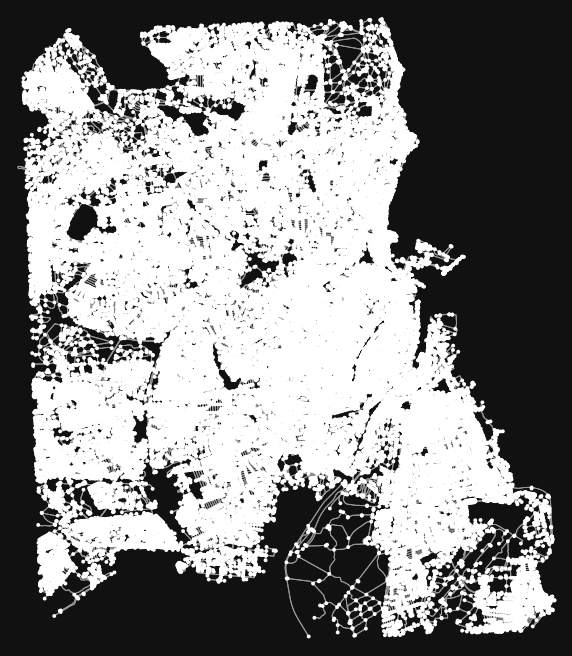

(<Figure size 720x1080 with 1 Axes>, <AxesSubplot:>)

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(10,15))
ax.set_axis_off()
fig.set_facecolor((0.065,0.065,0.065))    
ox.plot.plot_graph(graph, ax=ax)

In [6]:
# Simplify to get real intersections only
# (consolidate nodes within a distance from eachother)
graph_simplified = ox.simplification.consolidate_intersections(
    # Graph to simplify
    graph,
    # buffer around each node (project the graph beforehand)
    tolerance=10,
    # Get result as graph (False to get nodes only as gdf)
    rebuild_graph=True,
    # no dead ends
    dead_ends=False,
    # Reconnect (False to get intersections only)
    reconnect_edges=True
)

In [7]:
# everything to gdfs
nodes, edges = ox.graph_to_gdfs(graph)
nodes_s, edges_s = ox.graph_to_gdfs(graph_simplified)

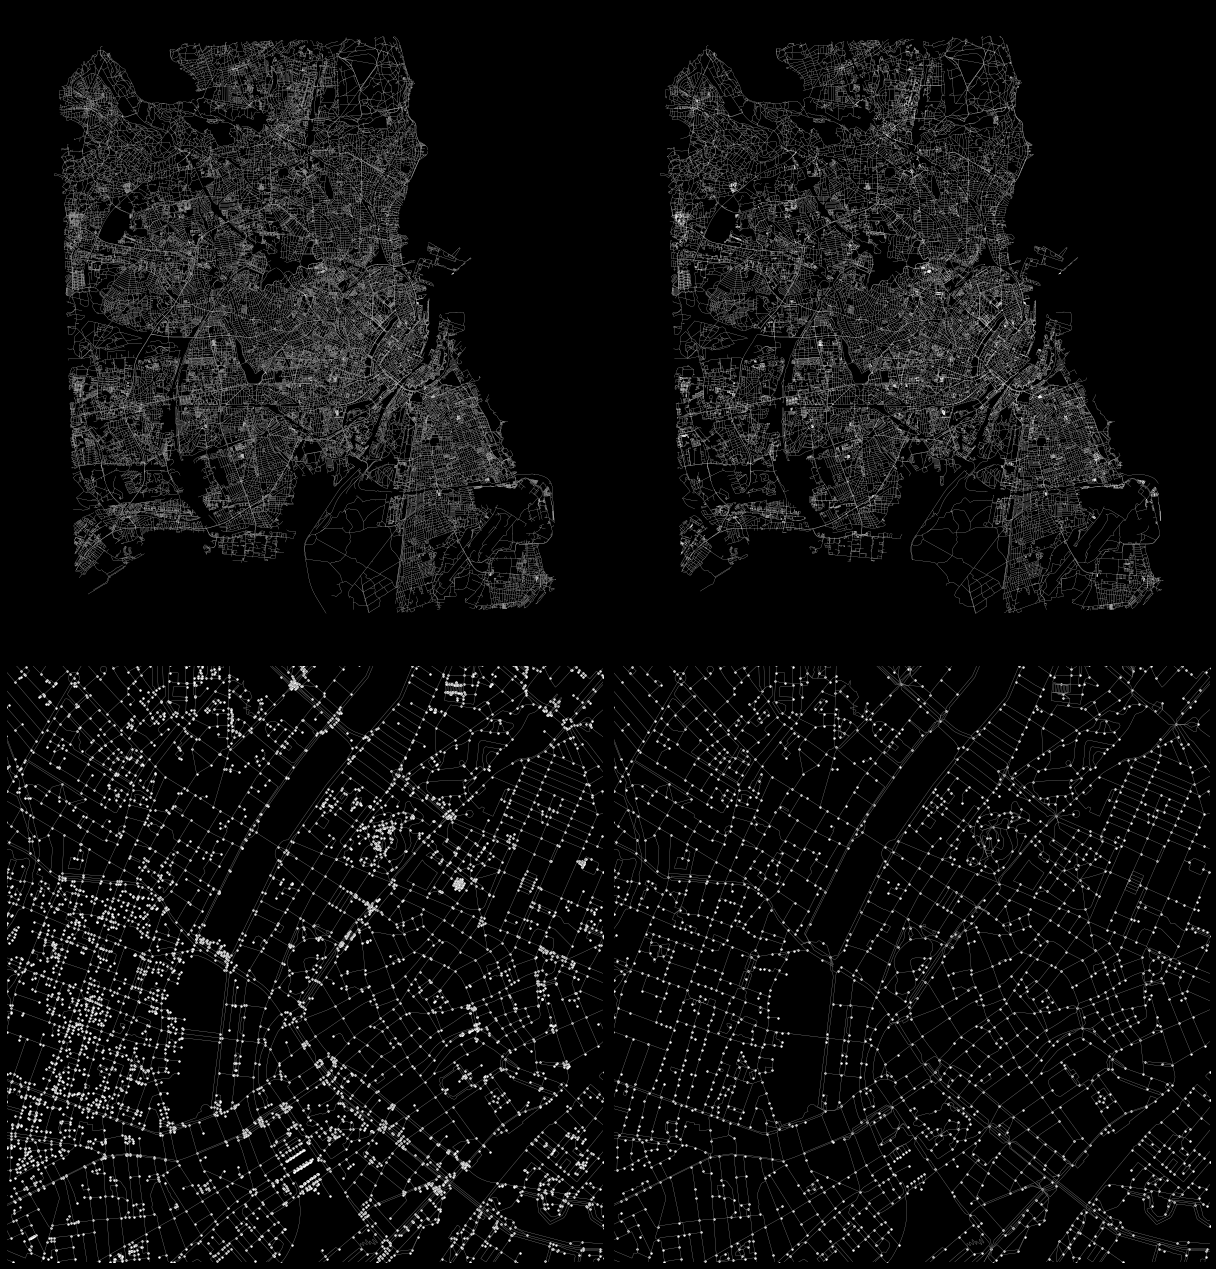

In [22]:
# Setup plot
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(17,18))
axs[0][0].set_axis_off()
axs[0][1].set_axis_off()
axs[1][0].set_axis_off()
axs[1][1].set_axis_off()
#fig.set_facecolor((0.065,0.065,0.065))
#fig.set_facecolor((0.004,0.016,0.035))
fig.set_facecolor((0,0,0))

# Plot data
# Row 1
edges.plot(
    ax=axs[0][0],
    color=[1,1,1],
    linewidth=0.1
)

edges_s.plot(
    ax=axs[0][1],
    color=[1,1,1],
    linewidth=0.1
)

# Row 2
edges.plot(
    ax=axs[1][0],
    color=[0.5,0.5,0.5],
    linewidth=0.2
)
nodes.plot(
    ax=axs[1][0],
    color=[1,1,1],
    markersize=2
)

edges_s.plot(
    ax=axs[1][1],
    color=[0.5,0.5,0.5],
    linewidth=0.2
)
nodes_s.plot(
    ax=axs[1][1],
    color=[1,1,1],
    markersize=2
)

# Zoom in row 2
plt.setp(axs[1][0], xlim=(4481000,4484000), ylim=(3621000,3624000))
plt.setp(axs[1][1], xlim=(4481000,4484000), ylim=(3621000,3624000))

# Tight layout 
plt.tight_layout()
plt.savefig('./docs/graph_comparison.png')

In [9]:
# Print info
print(
    'number of nodes:\n\noriginal graph: '+str(len(nodes))
    +'\nsimplified graph: '+str(len(nodes_s))
)

number of nodes:

original graph: 104839
simplified graph: 48001


In [10]:
# Calculate points in polygon
intersection_count = gpd.sjoin(grid, nodes_s).groupby('grid_id').size().reset_index()
intersection_count = intersection_count.rename(columns={0: 'intersections'})
grid_intersections = grid.merge(intersection_count, on='grid_id')

In [11]:
# Statistics
print(grid_intersections['intersections'].describe())

count    2587.000000
mean       17.988017
std        11.768793
min         1.000000
25%         8.000000
50%        17.000000
75%        26.000000
max        64.000000
Name: intersections, dtype: float64


<AxesSubplot:>

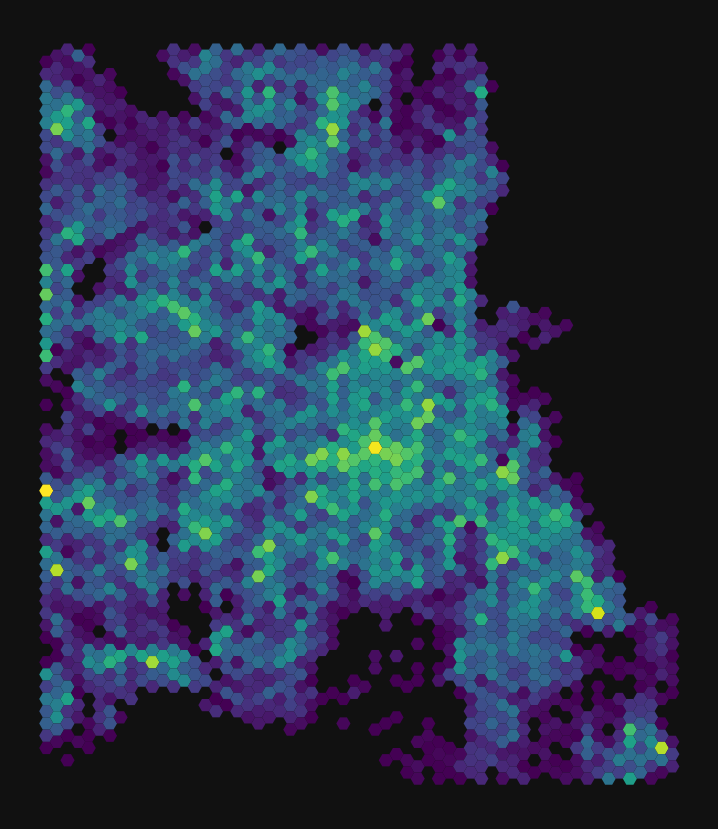

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
fig.set_facecolor((0.065,0.065,0.065))

grid_intersections.plot(
    ax=ax,
    column='intersections',
    scheme=None,
    cmap='viridis'
)

In [13]:
# Save nodes
#nodes.to_file('./data/nodes.gpkg', driver='GPKG')
#nodes_s.to_file('./data/intersections.gpkg', driver='GPKG')
#nodes_s_nd.to_file('./data/intersections_nd_'+city+'.gpkg', driver='GPKG')

In [14]:
#grid_intersections.to_file('./data/grid_intersections.gpkg', driver='GPKG')